In [8]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
import time
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
from riotwatcher import RiotWatcher
import requests

api_file = os.path.join('..','..','apikeys','LOL_api_key.txt')
with open(api_file, 'r') as fin:
    watcher = RiotWatcher(fin.readline())

/Users/bailey/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get matchids for masters** tier players
because there is no api call to just get a bunch matches I have to do some weird stuff. My strategy is: get challenger player list from the region -> getsummoner by playerid to get accountid -> get recent matches from each player -> check duplicates -> get match details

One note here is that the master tier isn't a constant size across regions unlike challenger. This is a possible source of bias in the data? Probably fine since there shouldn't be too too much difference across regions.

In [211]:
regions = ['RU', 'KR', 'BR1', 'OC1', 'JP1', 'NA1', 'EUN1', 'EUW1', 'TR1', 'LA1', 'LA2']
#regions = ['LA1', 'LA2']

gameid_list = {}
league_items = {}

#get last challenger games for each player in each region (purge duplicates)
#first loop through regions
for region in regions:
    
    #get all 'items' in the challenger league for solo queue (not sure about 'flex' queues?)
    #changed to master tier becuase that is the highest until mid january
    league_items[region] = watcher.league.masters_by_queue(region, 'RANKED_SOLO_5x5')['entries']
    
    #initialize gameid_list items
    gameid_list[region] = []

#loop through all items in each region's league to get matchid's
for region in regions:
    print(region)

    #get 100 matches from each player  
    for entry in league_items[region]:

        #convert player_id(aka summoner_id) to account_id
        account_id = watcher.summoner.by_id(region, entry['playerOrTeamId'])['accountId']

        #don't keep all matches in memory or on disk - we will get full match details later
        #queue = 420 is the code for 5x5_solo_queue
        match_list = watcher.match.matchlist_by_account(region,
                                     account_id,
                                     queue=420,
                                     begin_index = 1,
                                     end_index=100)['matches']
            
        #keep gameid_list in memory for later use and for easy purging of duplicates
        for match in match_list:
            gameid_list[region].append(match['gameId']) 

        #purge duplicates from gameid_list
        gameid_list[region] = list(set(gameid_list[region]))

       

RU
KR
BR1
OC1
JP1
NA1
EUN1
EUW1
TR1
LA1
LA2


In [216]:
with open(os.path.join('LOL_data','masters_tier','saved'+time.strftime('%Y-%m-%d')+'.json'), 'w') as fp:
    json.dump(gameid_list, fp)

# Get match details

In [217]:
lol_df = pd.DataFrame()
region_list = []
gameid_load_list = []
with open(os.path.join('LOL_Data','masters_tier','saved2018-12-22.json'),'r') as fp:
    for key, item in json.load(fp).items():
        region_list.extend([key] * len(item))
        gameid_load_list.extend(item)
        
lol_df['region'] = region_list
lol_df['gameid'] = gameid_load_list
lol_df.describe()

,gameid
count,1.784010e+05
mean,2.784957e+09
std,9.401525e+08
min,1.898462e+08
25%,2.033551e+09
50%,2.922288e+09
75%,3.463426e+09
max,3.872611e+09


In [218]:
#reindex randomly so that we don't loop through regions sequentially
#this way we more efficiently use the api calls we're allotted
lol_df = lol_df.reindex(np.random.permutation(lol_df.index))

In [219]:
blue_win = []
blue_champs = []
red_champs = []
bad_element_list = []
region_list = []
gameid_list = []
for i,row in lol_df[:].iterrows():
    
    #NOTE: Summoner spell info is included in match_details but may be hard to keep linked to participants
    #NOTE 2: Timeline info. can give timeline info on many things for teams and individual participants
    #   this could be used for training  a real time win probability model.
    try:
        match_details = watcher.match.by_id(row['region'],row['gameid'])   
    except requests.exceptions.HTTPError as err:
        print(err)
        print('Error at row:',row['gameid'])
        print('element:',i)
        bad_element_list.append(i)
        continue
    
    #append region_list and gameid_list so we don't have to
    #deal with wrong bad region, gameid
    region_list.append(row['region'])
    gameid_list.append(row['gameid'])
    
    #blue win is true if teamid=100 (blue) and this same team won
    blue_win.append(int(match_details['teams'][0]['win']=='Win' and match_details['teams'][0]['teamId']==100))

    #build team champion lineups and append to columns
    blue_champ_row = []
    red_champ_row = []
    for participant in match_details['participants']:
        if participant['teamId'] == 100:
            blue_champ_row.append(participant['championId'])
        elif participant['teamId'] ==200:
            red_champ_row.append(participant['championId'])
        else:
            print('Illegal team value!',participant['teamId'])
            break
    blue_champs.append(blue_champ_row)
    red_champs.append(red_champ_row)    

503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v3/matches/3392594045
Error at row: 3392594045
element: 19244
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v3/matches/620565660
Error at row: 620565660
element: 92945
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v3/matches/3642151133
Error at row: 3642151133
element: 175703
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v3/matches/3460229731
Error at row: 3460229731
element: 20064
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v3/matches/2910795126
Error at row: 2910795126
element: 155005
503 Server Error: Service Unavailable for url: https://eun1.api.riotgames.com/lol/match/v3/matches/2053927246
Error at row: 2053927246
element: 111361
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v3/matches/3642098624
Error at row: 3642098624
element: 172285
40

404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v3/matches/2908058635
Error at row: 2908058635
element: 160249
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v3/matches/624944562
Error at row: 624944562
element: 104798
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v3/matches/620180747
Error at row: 620180747
element: 94891
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v3/matches/622326926
Error at row: 622326926
element: 105652
429 Client Error: Too Many Requests for url: https://br1.api.riotgames.com/lol/match/v3/matches/1489342003
Error at row: 1489342003
element: 69314
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v3/matches/626142403
Error at row: 626142403
element: 79537
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v3/matches/3824014623
Error at row: 3824014623
element: 127098
500 Server Error: Ser

404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v3/matches/619994288
Error at row: 619994288
element: 82250
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v3/matches/2920064473
Error at row: 2920064473
element: 142779
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v3/matches/3642158630
Error at row: 3642158630
element: 176944
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v3/matches/3566928429
Error at row: 3566928429
element: 172210
503 Server Error: Service Unavailable for url: https://br1.api.riotgames.com/lol/match/v3/matches/1499087321
Error at row: 1499087321
element: 47803
500 Server Error: Server Error for url: https://kr.api.riotgames.com/lol/match/v3/matches/3462431234
Error at row: 3462431234
element: 11302
503 Server Error: Service Unavailable for url: https://kr.api.riotgames.com/lol/match/v3/matches/3434474936
Error at row: 3434474936
element: 41987
404 

404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v3/matches/622179424
Error at row: 622179424
element: 102019
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v3/matches/3559595347
Error at row: 3559595347
element: 173417
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v3/matches/3603910203
Error at row: 3603910203
element: 175593
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v3/matches/2910230681
Error at row: 2910230681
element: 141713
429 Client Error: Too Many Requests for url: https://eun1.api.riotgames.com/lol/match/v3/matches/2068408536
Error at row: 2068408536
element: 122246
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v3/matches/3836919856
Error at row: 3836919856
element: 87999
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v3/matches/3579685312
Error at row: 3579685312
element: 173990
404 Client Er

In [220]:
print(len(gameid_list)+len(bad_element_list))

178401


# Process match data and save to .csv

## Drop elements's from lol_df for which we got a HTTPError 
(all of these should be stored in bad_element_list). 
Not needed since we can just remake lol_df with the saved gameid+region lists

In [187]:
#drop bad gameid's from list
for bad_element in bad_element_list:
    lol_df = lol_df.drop(bad_element)

In [188]:
print(len(lol_df[:int(len(lol_df)/50)]))
print(len(bad_element_list))
print(len(blue_win))

4844
16
4828


## Process champion lists into np arrays.
Then add blue_win, blue_champ_array, and red_champ_array to lol_df.

In [221]:
#transform list of champion lists to np.array of champions.
#Shape is match x team (number of matches x 5 for each team)
blue_champ_array = np.zeros(shape=(len(blue_champs),5))
red_champ_array = np.zeros(shape=(len(red_champs),5))

if len(red_champ_array)!=len(blue_champ_array):
    pass

for i in range(len(blue_champ_array)):
    blue_champ_array[i] = blue_champs[i]
    red_champ_array[i] = red_champs[i]

print(blue_champ_array.shape)
print(red_champ_array.shape)

(178201, 5)
(178201, 5)


In [222]:
lol_df_processed = pd.DataFrame()

#Add radiant_win column to Dataframe
lol_df_processed['blue_win'] = np.array(blue_win)

#Add gameid
#Note: gameid can be duplicates across regions
lol_df_processed['gameid'] = gameid_list

#add region
lol_df_processed['region'] = region_list

#Add dire and radiant heroes to DataFrame under their own columns
for i in range(len(np.array(blue_champs)[1])):
    print(i)
    lol_df_processed['blue_champs'+str(i)] = blue_champ_array[:,i]
    lol_df_processed['red_champs'+str(i)] = red_champ_array[:,i]

0
1
2
3
4


In [223]:
#save data to csv file so we have it on disk
lol_df_processed.to_csv(os.path.join('LOL_data',
                                'masters_tier',
                                'saved'+
                                time.strftime('%Y-%m-%d')+
                                '.csv'))

# Load data and put it into a TFRecords file
Do this to nicely handle the features that is a numpy array (blue_champs and red_champs)

In [29]:
lol_df = None
for filename in glob.glob(os.path.join('LOL_data','masters_tier','*.csv')):
    if type(lol_df)==None:
        lol_df = pd.read_csv(filename, usecols=range(1,14))
    else:
        lol_df = pd.concat([lol_df, pd.read_csv(filename, usecols=range(1,14))],ignore_index=True)

lol_df = lol_df.reindex(np.random.permutation(lol_df.index))
lol_df.describe()

,blue_win,gameid,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,315422.000000,3.154220e+05,315422.000000,315422.000000,315422.000000,315422.000000,315422.000000,315422.000000,315422.000000,315422.000000,315422.000000,315422.000000
mean,0.501845,2.647077e+09,130.535105,130.338435,132.660341,132.024212,131.506626,131.423861,131.874413,132.113521,130.846644,130.231918
std,0.499997,1.043597e+09,129.995913,130.135548,131.748684,131.020219,130.975297,130.990961,130.866835,131.052393,130.518930,130.236730
min,0.000000,1.912299e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.527992e+09,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,1.000000,2.903045e+09,91.000000,91.000000,92.000000,92.000000,92.000000,91.000000,92.000000,92.000000,91.000000,91.000000
75%,1.000000,3.450169e+09,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
max,1.000000,3.872611e+09,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


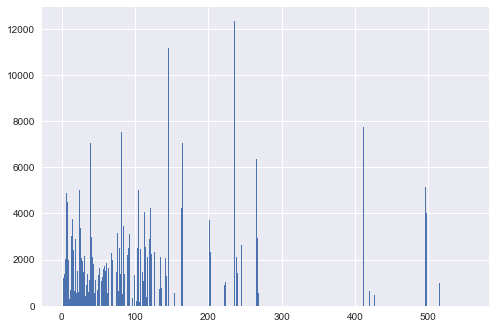

In [30]:
plt.hist(lol_df['blue_champs0'],bins=int(max(lol_df['blue_champs0'])))
plt.show()

In [31]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [32]:
def convert_to_tfrecords(filename, examples, targets):
    # open the TFRecords file
    writer = tf.python_io.TFRecordWriter(filename)
    
    blue_hero_array = np.array(examples['blue_champs'])
    red_hero_array = np.array(examples['red_champs'])
    target_array = np.array(targets['blue_win'])
    
    for i in range(len(blue_hero_array[:])):
        # print how many games are saved every 10000 games
        if not i % 10000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the image
        blue_champs = blue_hero_array[:][i].tostring()
        red_champs = red_hero_array[:][i].tostring()
        target = target_array[i]
        
        # Create a feature
        feature = {'blue_champs': _bytes_feature(tf.compat.as_bytes(blue_champs)),
                   'red_champs': _bytes_feature(tf.compat.as_bytes(red_champs)),
                   'targets': _int64_feature(target)}
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [33]:
def preprocess_features(lol_df):
    """Take lol_df and create a dataframe containing only the features for our model
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                processed_df: pandas DataFrame containing only feature columns
    """
    
    #Use arrays of champs for each team as features rather than each hero
    #individually to help model fit?
    #This is an attempt to make the model more similar to the movie review
    #text analysis example in the Google ML Crash Course
    processed_df = pd.DataFrame()
    
    processed_df['blue_champs'] = list(np.array(lol_df.loc[:,['blue_champs0',
                                                'blue_champs1','blue_champs2',
                                                'blue_champs3','blue_champs4']]).astype(int))
    processed_df['red_champs'] = list(np.array(lol_df.loc[:,['red_champs0',
                                    'red_champs1','red_champs2',
                                    'red_champs3','red_champs4']]).astype(int))
    ##only features (to start with) are the champs in the game
    #processed_df = lol_df[['blue_champs0', 'blue_champs1',
    #                   'blue_champs2', 'blue_champs3', 'blue_champs4',
    #                    'red_champs0', 'red_champs1', 'red_champs2',
    #                    'red_champs3', 'red_champs4']]
    
    ##create two synthetic features that is the product of all champs for each team
    #processed_df['blue_hero_product'] = lol_df['blue_champs0']*lol_df['blue_champs1']*lol_df['blue_champs2']lol_df['blue_champs3']*lol_df['blue_champs4']
    #processed_df['red_hero_product'] = lol_df['red_champs0']*lol_df['red_champs1']*lol_df['red_champs2']lol_df['red_champs3']*lol_df['red_champs4']
    
    return processed_df
    
def preprocess_targets(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column
    """
    target_df = pd.DataFrame()
    target_df['blue_win'] = lol_df['blue_win']
    
    return target_df

### Visualize data for each set

In [23]:
plotting_df = lol_df

display.display(plotting_df.iloc[:train_len,:].describe())
display.display(plotting_df.iloc[train_len:train_len+test_len,:].describe())
display.display(plotting_df.iloc[train_len+test_len:,:].describe())

,blue_win,gameid,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4
count,220795.000000,2.207950e+05,220795.000000,220795.000000,220795.000000,220795.000000,220795.000000,220795.000000,220795.000000,220795.000000,220795.000000
mean,0.501497,2.646822e+09,130.414027,130.204117,132.729179,132.031110,131.654272,131.109459,131.747603,131.969062,131.015485
std,0.499999,1.043352e+09,129.872101,130.070246,131.688058,131.131628,131.052697,130.705519,130.597339,130.927453,130.553677
min,0.000000,1.912299e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.528080e+09,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,1.000000,2.903043e+09,91.000000,91.000000,92.000000,92.000000,92.000000,91.000000,92.000000,92.000000,91.000000
75%,1.000000,3.450000e+09,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
max,1.000000,3.872611e+09,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


,blue_win,gameid,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4
count,63084.000000,6.308400e+04,63084.000000,63084.000000,63084.000000,63084.000000,63084.000000,63084.000000,63084.000000,63084.000000,63084.000000
mean,0.506357,2.646920e+09,130.216267,130.810982,132.541770,132.021257,131.266930,132.276219,132.294195,132.671010,131.132997
std,0.499964,1.043940e+09,129.642897,130.101886,131.926418,130.882917,131.087181,131.684051,131.611801,131.428493,131.055646
min,0.000000,1.912444e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.527763e+09,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,1.000000,2.902514e+09,91.000000,91.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,91.000000
75%,1.000000,3.450941e+09,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
max,1.000000,3.872581e+09,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


,blue_win,gameid,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4
count,31543.000000,3.154300e+04,31543.000000,31543.000000,31543.000000,31543.000000,31543.000000,31543.000000,31543.000000,31543.000000,31543.000000
mean,0.495260,2.649180e+09,132.020290,130.333576,132.415623,131.981834,130.952509,131.919951,131.922518,132.009764,129.092097
std,0.499985,1.044654e+09,131.552393,130.660733,131.820962,130.517656,130.209199,131.590703,131.258993,131.174421,129.184182
min,0.000000,1.912703e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.527789e+09,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,0.000000,2.903510e+09,92.000000,91.000000,92.000000,92.000000,91.000000,92.000000,92.000000,92.000000,91.000000
75%,1.000000,3.450925e+09,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,161.000000
max,1.000000,3.872601e+09,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


In [34]:
tier = 'masters'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
test_len = int((len(lol_df) - train_len)/1.5)
validation_len = len(lol_df) - train_len - test_len

train_features = preprocess_features(lol_df.iloc[:train_len,:])
train_targets = preprocess_targets(lol_df.iloc[:train_len,:])

test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
test_targets = preprocess_targets(lol_df.iloc[train_len:train_len+test_len,:])

validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])
validation_targets = preprocess_targets(lol_df.iloc[train_len+test_len:,:])

convert_to_tfrecords(os.path.join('LOL_data',tier+'_tier','lol_training_data', 'lol_training_data.tfrecords'),
                     train_features,
                     train_targets)

convert_to_tfrecords(os.path.join('LOL_data',tier+'_tier','lol_test_data', 'lol_test_data.tfrecords'),
                     test_features,
                     test_targets)

convert_to_tfrecords(os.path.join('LOL_data',tier+'_tier','lol_validation_data', 'lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets)


Train data: 0/220795
Train data: 10000/220795
Train data: 20000/220795
Train data: 30000/220795
Train data: 40000/220795
Train data: 50000/220795
Train data: 60000/220795
Train data: 70000/220795
Train data: 80000/220795
Train data: 90000/220795
Train data: 100000/220795
Train data: 110000/220795
Train data: 120000/220795
Train data: 130000/220795
Train data: 140000/220795
Train data: 150000/220795
Train data: 160000/220795
Train data: 170000/220795
Train data: 180000/220795
Train data: 190000/220795
Train data: 200000/220795
Train data: 210000/220795
Train data: 220000/220795
Train data: 0/63084
Train data: 10000/63084
Train data: 20000/63084
Train data: 30000/63084
Train data: 40000/63084
Train data: 50000/63084
Train data: 60000/63084
Train data: 0/31543
Train data: 10000/31543
Train data: 20000/31543
Train data: 30000/31543
